<a href="https://colab.research.google.com/github/zscialom/RL_Research/blob/test/Data_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [42]:
import numpy as np
import matplotlib
import statsmodels.api as sm
import scipy.io as sio  # for loading matlab data
import matplotlib.pyplot as plt
from google.colab import drive


In [8]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Data

In [9]:
ticker = 'GOOG'
period = '20141103'

data = sio.loadmat('/content/drive/Shared drives/ProjectML/Project/Nov-2014/'+ticker+'_'+period+'.mat')

# Data Preprocessing

In [11]:
LOB=data['LOB']

# Refer to"DataDescription.pdf" in the GitHub repo
# The file contains a structure called LOB where each field has entries corresponding to one second of the trading day

# time stamp is milliseconds from midnight at the start of the second
time_adj = 1e-3              # time adjustment: the time unit in raw data is millisecond
price_adj = 1e-4             # price correction: the price quoted in raw data is in price*1e4 form
t = (np.array((LOB['EventTime'][0][0][:,0]))-3600000*9.5)*time_adj    # converting time in seconds (hence 1e-3), measured from NASDAQ opening at 9:30am (hence 3600000*9.5)
bid = np.array(LOB['BuyPrice'][0][0]*price_adj)                       # bid price in the given 0.1 second interval 
bidvol = np.array(LOB['BuyVolume'][0][0]*1.0)                         # bid volumes in the given 0.1 second interval                  
ask = np.array(LOB['SellPrice'][0][0]*price_adj)                      # ask price in the given 0.1 second interval
askvol = np.array(LOB['SellVolume'][0][0]*1.0)                        # ask volumes in the given 0.1 second interval
nMO = np.array(LOB['NumberMO'][0][0]*1.0)                             # total number of MOs submitted in the given 0.1 second interval
vMO = np.array(LOB['VolumeMO'][0][0]*1.0)                             # total volume of MOs submitted in the given 0.1 second interval
MO=np.array(LOB['MO'][0][0]*1.0)                                      # information about market orders: number of MOs in the given 0.1 second interval
dt = t[1]-t[0] 

In [12]:
# Midprice
midprice = 0.5*(bid[:,0]+ask[:,0])
#print(midprice)

# Microprice
microprice = (bid[:,0]*askvol[:,0]+ask[:,0]*bidvol[:,0])/(bidvol[:,0]+askvol[:,0])

# LO imbalance for each time stamp
rho = np.array((bidvol[:,0]-askvol[:,0])/(bidvol[:,0]+askvol[:,0]),ndmin=2).T

In [21]:
secondFreq = 10 # variable needed to work with seconds
oneMinute = 60 

#thirtyMin = (178*60+55)*secondFreq                 # 16:00 - 2 hours 58 minutes 55 seconds 5steps
#thirtyMin = (177*60+20)*secondFreq                 # 16:00 - 2 hours 57 minutes 20 seconds 100steps
#thirtyMin = (178*60+50)*secondFreq                 # 16:00 - 2 hours 58 minutes 50 seconds 10steps
thirtyMin = (178*60+10)*secondFreq                  # 16:00 - 2 hours 58 minutes 10 seconds 50steps

# Length of estimation window - 1 hour
N = oneMinute*secondFreq  

# Looking for Upward Trend

In [45]:
r_midprice = midprice[1:]/midprice[:-1]

In [55]:
z_stat = 1.96
r_test = r_midprice - 1
r_test = (r_test-np.mean(r_test))/np.std(r_test)
upward_starts = []

for i in range(len(midprice)-N):           
  model = sm.stats.ztest(r_test[i:i+N],value=0,alternative='larger')
  if model[0]>z_stat:
    upward_starts.append(i)

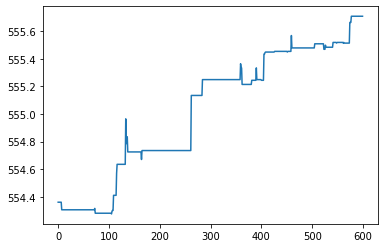

In [57]:
plt.plot(midprice[upward_starts[0]:upward_starts[0]+N])